In [214]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns 

from utils import *

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#from prettytable import PrettyTable

import warnings
warnings.filterwarnings("ignore")

In [215]:
path_data = 'data/pump_sensor.csv'

In [216]:
import pandas as pd

datafull=pd.read_csv(path_data)

data = datafull.iloc[:,2:-1]

print(data.shape)
print(data.keys())

(220320, 52)
Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19',
       'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24',
       'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29',
       'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34',
       'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39',
       'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44',
       'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49',
       'sensor_50', 'sensor_51'],
      dtype='object')


In [217]:
data.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037
3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250
4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889


In [218]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 52 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   sensor_00  210112 non-null  float64
 1   sensor_01  219951 non-null  float64
 2   sensor_02  220301 non-null  float64
 3   sensor_03  220301 non-null  float64
 4   sensor_04  220301 non-null  float64
 5   sensor_05  220301 non-null  float64
 6   sensor_06  215522 non-null  float64
 7   sensor_07  214869 non-null  float64
 8   sensor_08  215213 non-null  float64
 9   sensor_09  215725 non-null  float64
 10  sensor_10  220301 non-null  float64
 11  sensor_11  220301 non-null  float64
 12  sensor_12  220301 non-null  float64
 13  sensor_13  220301 non-null  float64
 14  sensor_14  220299 non-null  float64
 15  sensor_15  0 non-null       float64
 16  sensor_16  220289 non-null  float64
 17  sensor_17  220274 non-null  float64
 18  sensor_18  220274 non-null  float64
 19  sensor_19  220304 non-n

In [219]:
''' 
Get some info on the target-data
'''

print( 'status options: ');  print( datafull['machine_status'].unique()); print() # Get the unique values for class
print (datafull['machine_status'].value_counts()); print() # Count the Classes to see how many we got from each

status options: 
['NORMAL' 'BROKEN' 'RECOVERING']

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64



In [220]:
'''
Convert the classes from string to values by using the scikit-learn mapper
'''

le = preprocessing.LabelEncoder() #get the label Encoder
le.fit(datafull.machine_status) #fit it to the data that the encoder knows what to do
encoded_y=le.transform(datafull.machine_status) #finally transform the data and put it into a pandas data frame for easier use

#Get the Label map
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_))) # To be able to later indentify what is what, create a label map
print(le_name_mapping)

{'BROKEN': 0, 'NORMAL': 1, 'RECOVERING': 2}


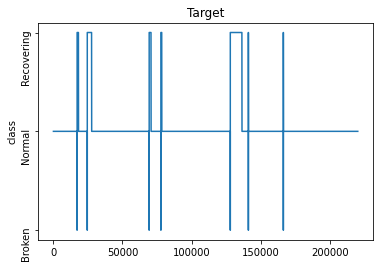

In [221]:
'''
Plot the  target data
'''

x = np.linspace(1, len(encoded_y), len(encoded_y))# create x-axis (could also be the converted timestamp column)
plt.plot(x, encoded_y) 
plt.ylabel('class')
plt.title('Target')
labels = ['Normal','Broken','Recovering'] # Give the y-axis the Class lables we found earlier
plt.yticks([1,0,2], labels, rotation='vertical') # Set the y-ticks to three to only show the classnames
plt.show()  

In [222]:
datafull['machine_status'].loc[datafull['machine_status'] =='BROKEN'] = 0
datafull['machine_status'].loc[datafull['machine_status'] =='NORMAL'] = 1
datafull['machine_status'].loc[datafull['machine_status'] =='RECOVERING'] = 2

In [223]:
datafull['machine_status'].value_counts()

1    205836
2     14477
0         7
Name: machine_status, dtype: int64

#### Rimuoviamo le righe duplicate

In [224]:
data.drop_duplicates(inplace=True)
datafull.drop_duplicates(inplace=True)

#### Removing NaNs

Text(0.5, 1.0, 'Count NaN')

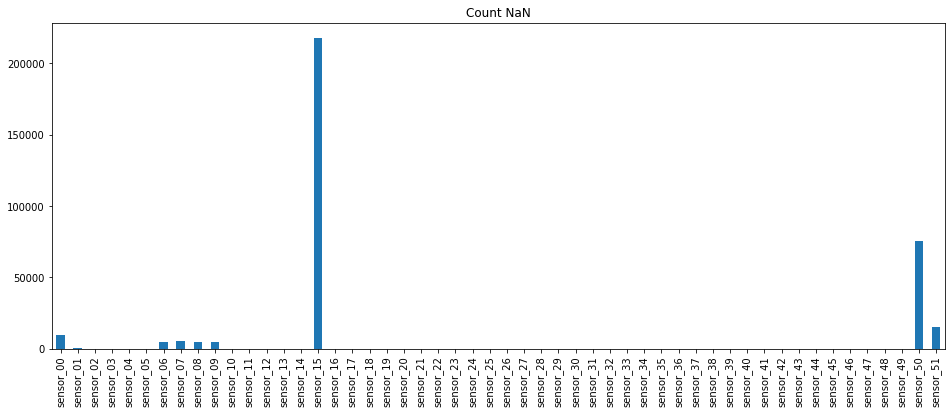

In [225]:
plt.figure(figsize=(16,6))
data.isna().sum()[data.isna().sum()>0].plot(kind='bar')
plt.title('Count NaN')

Text(0.5, 1.0, 'Removing Sensor 15')

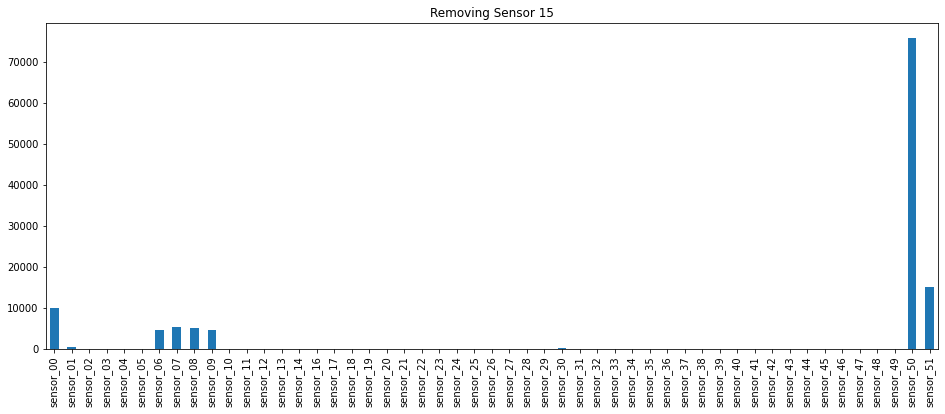

In [226]:
plt.figure(figsize=(16,6))

data.drop('sensor_15', inplace=True, axis=1)
datafull.drop('sensor_15', inplace=True, axis=1)

data.isna().sum()[data.isna().sum()>0].plot(kind='bar')
plt.title('Removing Sensor 15')

Text(0.5, 1.0, 'Focus sensos 50')

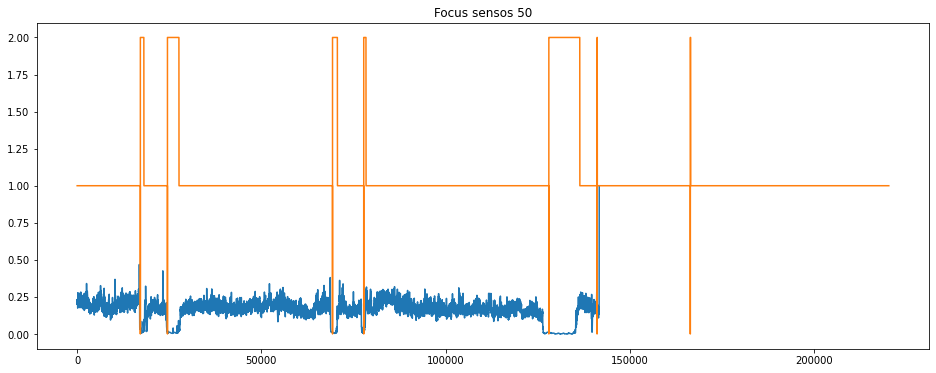

In [227]:
from sklearn.preprocessing import MinMaxScaler
plt.figure(figsize=(16,6))

scaler = MinMaxScaler()
scaled_dat = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
plt.plot(scaled_dat.sensor_50)

x = np.linspace(1, len(encoded_y), len(encoded_y))# create x-axis (could also be the converted timestamp column)
plt.plot(x, encoded_y)
plt.title('Focus sensos 50')


Text(0.5, 1.0, 'Focus sensos 51')

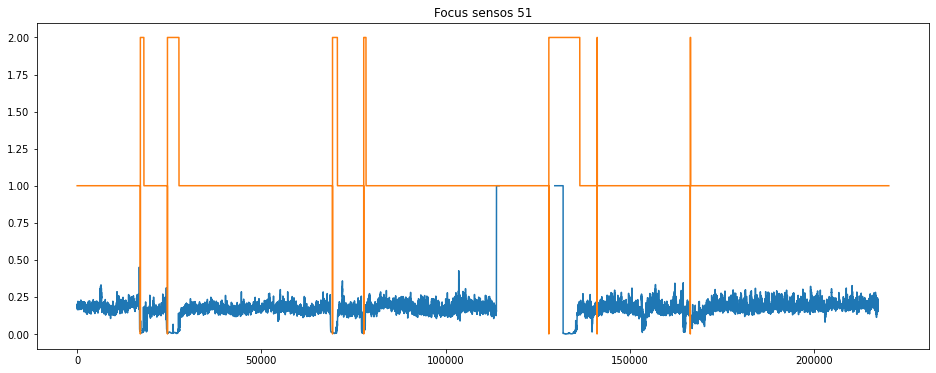

In [228]:
from sklearn.preprocessing import MinMaxScaler
plt.figure(figsize=(16,6))

scaler = MinMaxScaler()
scaled_dat = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
plt.plot(scaled_dat.sensor_51)

x = np.linspace(1, len(encoded_y), len(encoded_y))# create x-axis (could also be the converted timestamp column)
plt.plot(x, encoded_y) 
plt.title('Focus sensos 51')


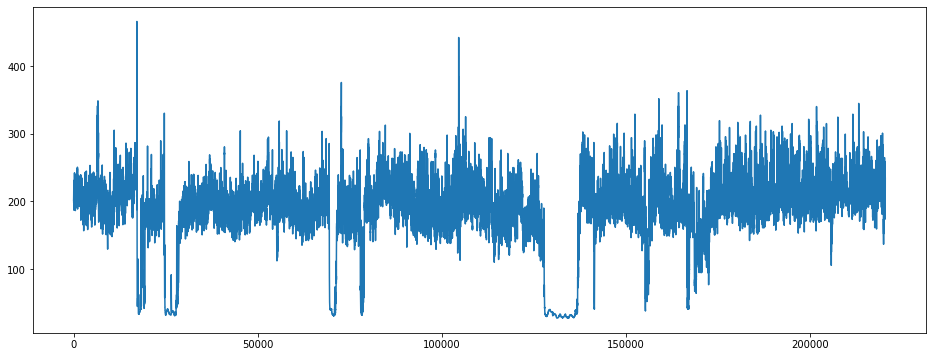

In [229]:
plt.figure(figsize=(16,6))

# repair sensor 50 with 51 data
data.sensor_51[110000:140000]=data.sensor_50[110000:140000] # repair sensor 51
datafull.sensor_51[110000:140000]=datafull.sensor_50[110000:140000] # repair sensor 51

# drop sensor 50
data.drop('sensor_50', inplace=True, axis=1)
datafull.drop('sensor_50', inplace=True, axis=1)

plt.plot(data.sensor_51)

In [230]:
data.columns

Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_51'],
      dtype='object')

Text(0.5, 1.0, 'Dropped sensor 15, 50 and fixed 51')

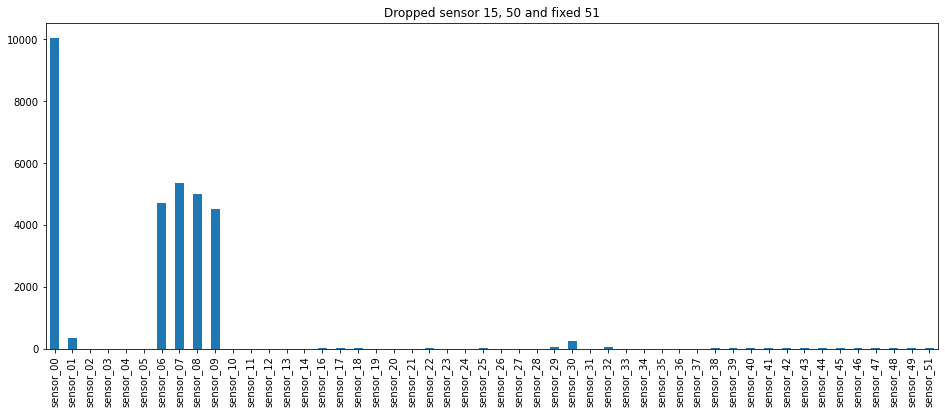

In [231]:
plt.figure(figsize=(16,6))
data.isna().sum()[data.isna().sum()>0].plot(kind='bar')
plt.title('Dropped sensor 15, 50 and fixed 51')

<AxesSubplot:title={'center':'Var'}>

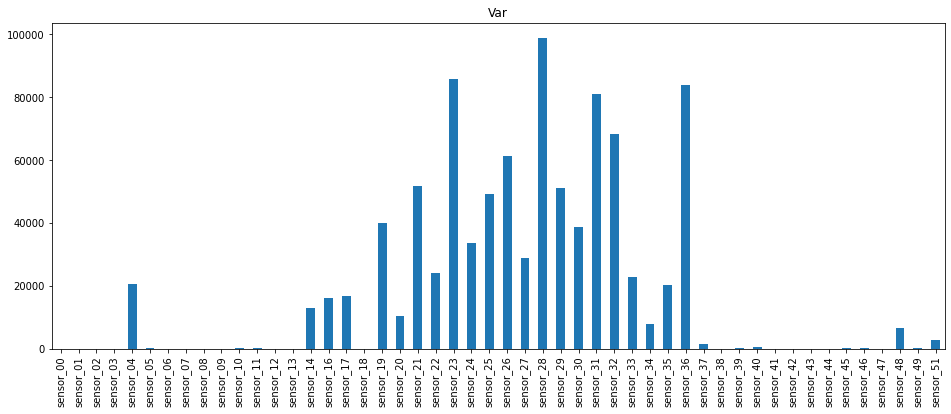

In [232]:
plt.figure(figsize=(16,6))
plt.title('Var')
data.var().plot(kind='bar')

si osserva come i senso 00 e 06-09 pur avendo dei valori mancando non hanno molta varianza, pe cui dediciamo allora di rimuoverli siccome non penso portino molta informzione

In [233]:
"""
data.drop('sensor_00', inplace=True, axis=1)
data.drop('sensor_06', inplace=True, axis=1)
data.drop('sensor_07', inplace=True, axis=1)
data.drop('sensor_08', inplace=True, axis=1)
data.drop('sensor_09', inplace=True, axis=1)

datafull.drop('sensor_00', inplace=True, axis=1)
datafull.drop('sensor_06', inplace=True, axis=1)
datafull.drop('sensor_07', inplace=True, axis=1)
datafull.drop('sensor_08', inplace=True, axis=1)
datafull.drop('sensor_09', inplace=True, axis=1)
"""

"\ndata.drop('sensor_00', inplace=True, axis=1)\ndata.drop('sensor_06', inplace=True, axis=1)\ndata.drop('sensor_07', inplace=True, axis=1)\ndata.drop('sensor_08', inplace=True, axis=1)\ndata.drop('sensor_09', inplace=True, axis=1)\n\ndatafull.drop('sensor_00', inplace=True, axis=1)\ndatafull.drop('sensor_06', inplace=True, axis=1)\ndatafull.drop('sensor_07', inplace=True, axis=1)\ndatafull.drop('sensor_08', inplace=True, axis=1)\ndatafull.drop('sensor_09', inplace=True, axis=1)\n"

<AxesSubplot:>

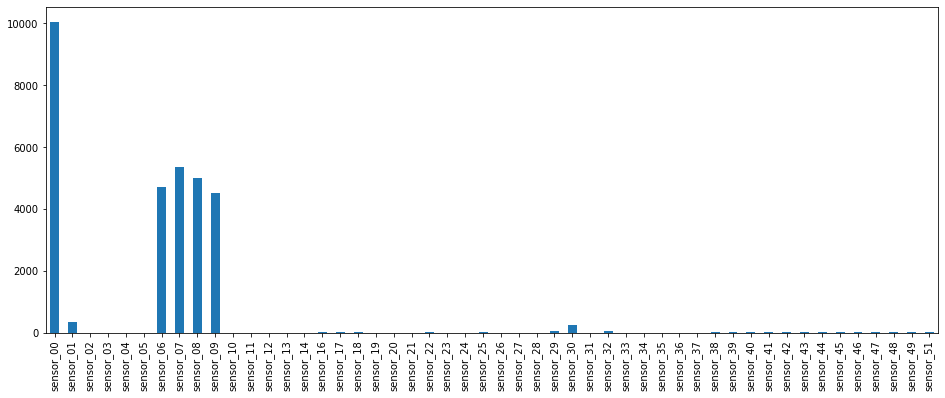

In [234]:
plt.figure(figsize=(16,6))
data.isna().sum()[data.isna().sum()>0].plot(kind='bar')

In [235]:
"""
plt.figure(figsize=(16,6))

data.fillna(method="pad", limit=30, inplace=True) # fill degli na con PAD mode e fino a 30 na consecutivi, il resto lascia na
data.dropna(inplace=True)

datafull.fillna(method="pad",limit=30, inplace=True) # fill degli na con PAD mode e fino a 30 na consecutivi, il resto lascia na
datafull.dropna(inplace=True)
"""

plt.figure(figsize=(16,6))

data.fillna(-1, inplace=True) # fill degli na con PAD mode e fino a 30 na consecutivi, il resto lascia na
data.dropna(inplace=True)

datafull.fillna(-1, inplace=True) # fill degli na con PAD mode e fino a 30 na consecutivi, il resto lascia na
datafull.dropna(inplace=True)

<Figure size 1152x432 with 0 Axes>

#### Feature Engineering

In [236]:
datafull.reset_index(inplace=True)
datafull.drop('id', inplace=True, axis=1)

In [237]:
datafull.head()

,index,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,1
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,1
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,203.7037,1
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,203.1250,1
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,201.3889,1


Moreover, plot of machine status variation with time shows that Recovering state follows Broken state and in Recovering state pump is trying to recover from Broken state so Recovering state is considered as Broken state.

In [238]:

datafull['machine_status'].loc[(datafull['machine_status'] == 0) | (datafull['machine_status'] == 2) ] = 0

In [239]:
datafull['machine_status'].value_counts()

1    205836
0     14484
Name: machine_status, dtype: int64

Because of limited availability data, selected time window of 10 minute for prediction i. e. given a data point predict the machine status after 10 minute. Therefore data is pre-processed by shifting the labels by 10 minute.

In [240]:
#final_sensors = ['sensor_04', 'sensor_19', 'sensor_20', 'sensor_21', 
#                 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41', 
#                 'sensor_42']

final_sensors = ['sensor_00', 'sensor_02', 'sensor_04', 'sensor_06',  'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_51' ]

In [241]:
datafull = datafull[final_sensors]
datafull.head()

,sensor_00,sensor_02,sensor_04,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_51
0,2.465394,53.2118,634.3750,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,201.3889
1,2.465394,53.2118,634.3750,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,201.3889
2,2.444734,53.2118,638.8889,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,203.7037
3,2.460474,53.1684,628.1250,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,203.1250
4,2.445718,53.2118,636.4583,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,201.3889


## LSTM

In [242]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [307]:
values_2 = datafull.values
n_train_time = 130000
train = values_2[:n_train_time, :]
test = values_2[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [309]:
from sklearn.preprocessing import MinMaxScaler

values = datafull.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(datafull.shape[1]+1, 2*datafull.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var1(t)
0,0.976438,0.950534,0.793227,0.619817,0.696492,0.653563,0.617443,0.495772,0.795479,0.433246,0.976438
1,0.970617,0.950534,0.798863,0.616083,0.692669,0.655560,0.615774,0.504077,0.806184,0.438201,0.976438
2,0.975052,0.949773,0.785424,0.615772,0.701198,0.658699,0.618557,0.513311,0.814034,0.436962,0.970617
3,0.970894,0.950534,0.795828,0.617328,0.699727,0.658699,0.618557,0.525107,0.820705,0.433246,0.975052
4,0.973111,0.949773,0.797273,0.619817,0.697962,0.666404,0.621617,0.522574,0.825746,0.433865,0.970894


In [310]:
# Data spliting into train and test data series.
values = reframed.values
n_train_time = 130000
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [311]:
test_y

array([0.        , 0.        , 0.        , ..., 0.95814248, 0.95703372,
       0.95980576])

In [245]:
test.shape

(90319, 11)

In [246]:
test_x.shape

(90319, 1, 10)

In [247]:
train_y.shape

(130000,)

In [248]:
test_y.shape

(90319,)

In [249]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K


model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid') )
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])

# Network fitting
history = model.fit(train_x, train_y, epochs=50, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Epoch 1/50
1858/1858 - 9s - loss: 0.1902 - f1_m: 0.9200 - val_loss: 0.4589 - val_f1_m: 0.9044 - 9s/epoch - 5ms/step
Epoch 2/50
1858/1858 - 6s - loss: 0.1576 - f1_m: 0.9223 - val_loss: 0.2752 - val_f1_m: 0.9139 - 6s/epoch - 3ms/step
Epoch 3/50
1858/1858 - 6s - loss: 0.1545 - f1_m: 0.9225 - val_loss: 0.2717 - val_f1_m: 0.9143 - 6s/epoch - 3ms/step
Epoch 4/50
1858/1858 - 6s - loss: 0.1533 - f1_m: 0.9230 - val_loss: 0.2606 - val_f1_m: 0.9147 - 6s/epoch - 3ms/step
Epoch 5/50
1858/1858 - 6s - loss: 0.1525 - f1_m: 0.9234 - val_loss: 0.2478 - val_f1_m: 0.9149 - 6s/epoch - 3ms/step
Epoch 6/50
1858/1858 - 6s - loss: 0.1520 - f1_m: 0.9237 - val_loss: 0.2389 - val_f1_m: 0.9151 - 6s/epoch - 3ms/step
Epoch 7/50
1858/1858 - 6s - loss: 0.1516 - f1_m: 0.9237 - val_loss: 0.2340 - val_f1_m: 0.9155 - 6s/epoch - 3ms/step
Epoch 8/50
1858/1858 - 6s - loss: 0.1512 - f1_m: 0.9236 - val_loss: 0.2329 - val_f1_m: 0.9156 - 6s/epoch - 3ms/step
Epoch 9/50
1858/1858 - 6s - loss: 0.1509 - f1_m: 0.9236 - val_loss: 0.23

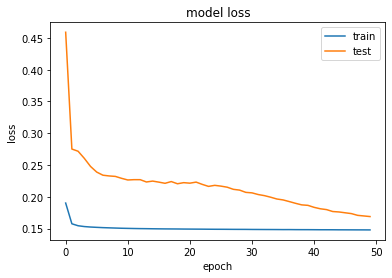

In [250]:
# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [251]:
size = datafull.shape[1]
size

10

In [257]:
test_y.reshape((len(test_y))).shape

(90319,)

In [312]:
#test_x = test_x.reshape((test_x.shape[0], size))
#test_y = test_y.reshape((len(test_y), 1))

scores = model.evaluate(test_x, test_y, verbose=0)
print("F1-Score: %.2f%%" % (scores[1]*100))

pred =  model.predict(test_x)

F1-Score: 91.55%
2823/2823 [==============================] - 3s 1ms/step


In [211]:
def get_confusion_mat( y_true , y_pred):
    """
    Function to plot confusion matrix
    """
    # counfusion matrix
    confusion_mat = confusion_matrix(y_true , y_pred)
        
    labels = ["Broken", "Normal"]

    # plot heat map of confusion matrix
    sns.heatmap(confusion_mat, annot=True, fmt='', cmap='Greens',
                xticklabels=labels, 
                yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [297]:
get_confusion_mat(test_y, pred)

ValueError: continuous is not supported

In [313]:
pred

array([[0.00901443],
       [0.00888398],
       [0.00905844],
       ...,
       [0.899867  ],
       [0.9024158 ],
       [0.9025468 ]], dtype=float32)

In [130]:
size = datafull.shape[1]

# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
#rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)

2022-10-06 21:30:59.855578: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at transpose_op.cc:142 : INVALID_ARGUMENT: transpose expects a vector of size 2. But input(1) is a vector of size 3


InvalidArgumentError: Graph execution error:

transpose expects a vector of size 2. But input(1) is a vector of size 3
	 [[{{node transpose}}]]
	 [[sequential_5/lstm_5/PartitionedCall]] [Op:__inference_predict_function_667113]

In [128]:
f1_macro = f1_score(inv_y, inv_yhat, average='macro')
f1_macro

ValueError: continuous is not supported

In [109]:
inv_y.shape

(90319,)

In [108]:
inv_yhat.shape

(90319,)